(get-started-dask-dataframe)=
# Getting Started with Dask DataFrame

In this section, we will demonstrate how to parallelize pandas DataFrame using Dask DataFrame.

## Creating Dask DataFrame

We can generate a Dask DataFrame named `ddf`, which is a time series dataset that is randomly generated. Each data sample represents one second, totaling four days (from 2024-01-01 0:00 to 2024-01-05 0:00).

In [1]:
import dask

ddf = dask.datasets.timeseries(start="2024-01-01",
    end="2024-01-05")
ddf

Dask DataFrame Structure:
                 name     id        x        y
npartitions=4                                 
2024-01-01     string  int64  float64  float64
2024-01-02        ...    ...      ...      ...
2024-01-03        ...    ...      ...      ...
2024-01-04        ...    ...      ...      ...
2024-01-05        ...    ...      ...      ...
Dask Name: to_pyarrow_string, 2 graph layers

All operations in pandas are executed immediately (i.e., Eager Execution). Dask, on the other hand, is executed lazily, and the above data has not been computed, hence represented by ellipsis (...).

While the data in the Dask DataFrame (`ddf`) has not been computed yet, Dask has already retrieved the column names and data types. You can view this information using the `dtypes` attribute:

In [2]:
ddf.dtypes

name    string[pyarrow]
id                int64
x               float64
y               float64
dtype: object

## Trigger Computation

To compute and obtain results, it is necessary to manually trigger the computation using the `compute()` method.

In [3]:
ddf.compute()

name    id         x         y
timestamp                                             
2024-01-01 00:00:00    Zelda   988 -0.873067  0.157726
2024-01-01 00:00:01   Oliver   978  0.261735  0.516558
2024-01-01 00:00:02   Victor   985  0.510027 -0.259912
2024-01-01 00:00:03   Yvonne   999 -0.488090  0.463293
2024-01-01 00:00:04   Hannah   978 -0.879385  0.886313
...                      ...   ...       ...       ...
2024-01-04 23:59:55   Xavier   995  0.650247 -0.699778
2024-01-04 23:59:56  Michael  1027 -0.850668  0.867499
2024-01-04 23:59:57   Ursula   969  0.032713  0.125985
2024-01-04 23:59:58   Victor   999 -0.481142  0.920718
2024-01-04 23:59:59    Edith  1023  0.366130  0.296003

[345600 rows x 4 columns]

Dask DataFrame has a crucial built-in variable called `npartitions`. It signifies the number of divisions or partitions the data has been split into. As illustrated in {numref}`dask-dataframe-partition`, a Dask DataFrame comprises multiple pandas DataFrames, with each pandas DataFrame referred to as a partition.

In [4]:
ddf.npartitions

4

```{figure} ../img/ch-dask/dask-dataframe.svg
---
width: 400px
name: dask-dataframe-partition
---
A Dask DataFrame comprises multiple pandas DataFrames
```
Each partition in a Dask DataFrame is defined by upper and lower bounds. In this example, `ddf` is partitioned based on the time column, with each day's data forming a distinct partition. The built-in variable `divisions` holds the boundary lines for each partition:

In [5]:
ddf.divisions

(Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-02 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-04 00:00:00'),
 Timestamp('2024-01-05 00:00:00'))

## Index

:::{note}
In a pandas DataFrame, there is a dedicated column for storing the index, which can be numeric, such as row numbers, or temporal. The index column is typically used solely for indexing purposes and is not considered a data field; hence, it is not visible in `ddf.dtypes`.
:::

In this example, the index of `ddf` is temporal, and each partition boundary is based on this index column. The entire `ddf` spans four days of data, with each partition representing a single day.

Now, let's select data from 2024-01-01 0:00 to 2024-01-02 5:00, spanning two days and two partitions.

In [6]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"]

Dask DataFrame Structure:
                                 name     id        x        y
npartitions=2                                                 
2024-01-01 00:00:00.000000000  string  int64  float64  float64
2024-01-02 00:00:00.000000000     ...    ...      ...      ...
2024-01-02 05:00:59.999999999     ...    ...      ...      ...
Dask Name: loc, 3 graph layers

Use `compute()` to trigger the computation and obtain the results:

In [7]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"].compute()

name    id         x         y
timestamp                                              
2024-01-01 00:00:00     Zelda   988 -0.873067  0.157726
2024-01-01 00:00:01    Oliver   978  0.261735  0.516558
2024-01-01 00:00:02    Victor   985  0.510027 -0.259912
2024-01-01 00:00:03    Yvonne   999 -0.488090  0.463293
2024-01-01 00:00:04    Hannah   978 -0.879385  0.886313
...                       ...   ...       ...       ...
2024-01-02 05:00:55       Bob  1029  0.218520  0.462808
2024-01-02 05:00:56     Alice  1005  0.722850  0.067173
2024-01-02 05:00:57       Tim   990 -0.343179 -0.812177
2024-01-02 05:00:58  Patricia   999  0.995964 -0.669022
2024-01-02 05:00:59     Jerry  1089 -0.925839  0.004172

[104460 rows x 4 columns]

## Pandas Compatibility

Most operations of Dask DataFrame and pandas are similar, allowing us to employ Dask DataFrame much like we would with pandas.

For instance, data filtering and groupby operations are conducted in a manner analogous to pandas:

In [8]:
ddf2 = ddf[ddf.y > 0]
ddf3 = ddf2.groupby("name").x.std()
ddf3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 10 graph layers

The results are still represented by ellipsis (...) because the computation is deferred and requires invoking `compute()` to trigger execution.

In [9]:
computed_ddf = ddf3.compute()
computed_ddf

name
Alice       0.570873
Bob         0.574338
Charlie     0.577622
Dan         0.578480
Edith       0.579528
Frank       0.576647
George      0.576759
Hannah      0.580472
Ingrid      0.579585
Jerry       0.577015
Kevin       0.574981
Laura       0.578379
Michael     0.574430
Norbert     0.575075
Oliver      0.577198
Patricia    0.579569
Quinn       0.573159
Ray         0.577756
Sarah       0.573136
Tim         0.574545
Ursula      0.580282
Victor      0.578231
Wendy       0.576533
Xavier      0.578146
Yvonne      0.576635
Zelda       0.570968
Name: x, dtype: float64

## Computational Graph

Until now, we understand that Dask DataFrame divides large datasets into partitions and operates with a deferred execution manner. Before executing `compute()`, Dask has built a Task Graph, and you can visualize this Task Graph using `visualize()`:

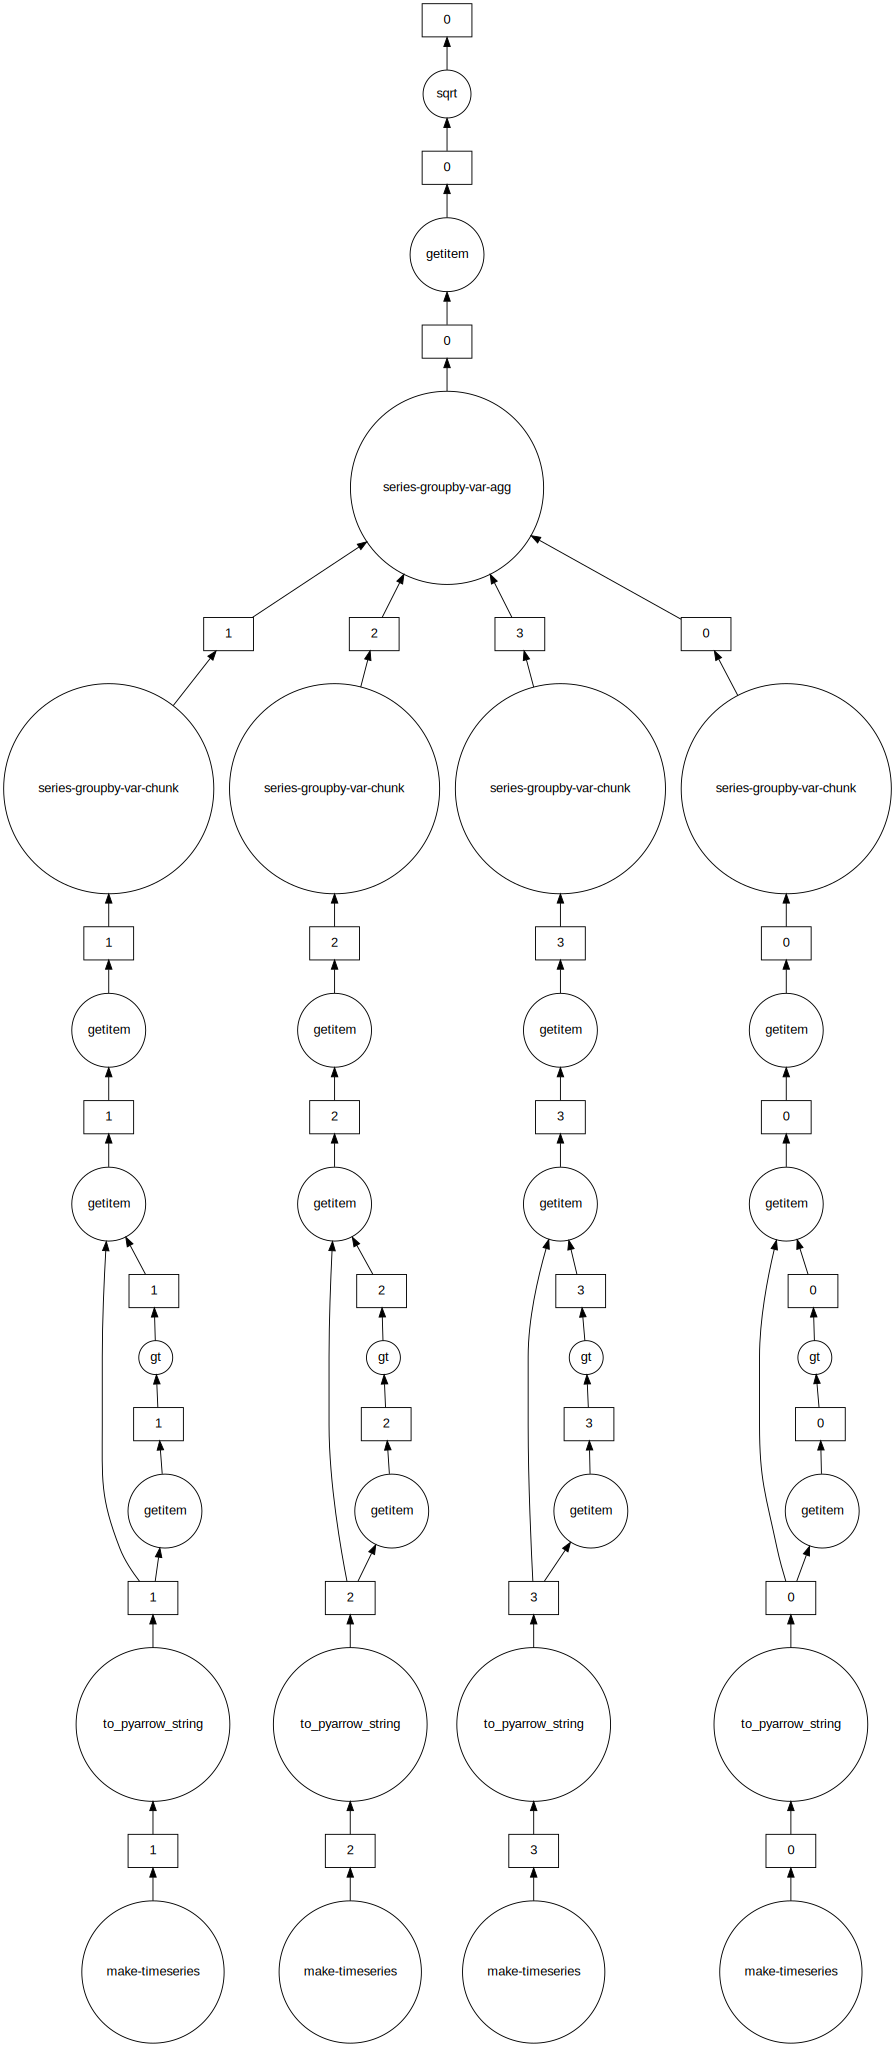

In [10]:
ddf3.visualize(filename="../img/ch-dask/visualize-task-graph", format="svg")

In the Task Graph, circles represent computations, and rectangles represent data. For Dask DataFrame, the rectangles correspond to pandas DataFrame partitions.